### This Jupyternotebook file contains the python codes to reproduce the paper figures.

# Definition of TropEmbed class (commonly used for all figures)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import repeat_elements
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt 

class TropEmbed(Layer):
    def __init__(self, units=2, input_dim=3):
        super(TropEmbed, self).__init__()
        self.w = self.add_weight(shape=(units, input_dim), initializer="random_normal")
        self.units = units
        self.input_dim = input_dim

    def call(self, x):
        x_reshaped = tf.reshape(x,[-1, 1, self.input_dim])
        x_for_broadcast = repeat_elements(x_reshaped, self.units, 1)
        values, indices = tf.math.top_k(x_for_broadcast + self.w, self.input_dim)
        return values[:,:,0] - values[:,:,-1]

# Figure 2 for weight initialization

In [2]:
# Lemma 14
N=10000
a = 1/np.sqrt(2*np.log(N))
b = 1/a - (np.log(np.log(N))+np.log(4*np.pi))/2*a

# dtr = max - min
x = randn(N,100000)*np.sqrt(2)
dtr = np.max(x, axis=0) - np.min(x, axis=0)

# print(np.cov(np.max(x, axis=0), np.min(x, axis=0))) # zero covariance

# mean and std
print(np.mean(dtr))
print(2*np.sqrt(2)*(a*np.euler_gamma+b)) # theory
print(np.std(dtr))
print(np.sqrt(np.pi*np.pi/3/np.log(N))) # theory

10.892610213768942
10.954213589762672
0.6041338162905445
0.5976561671759354


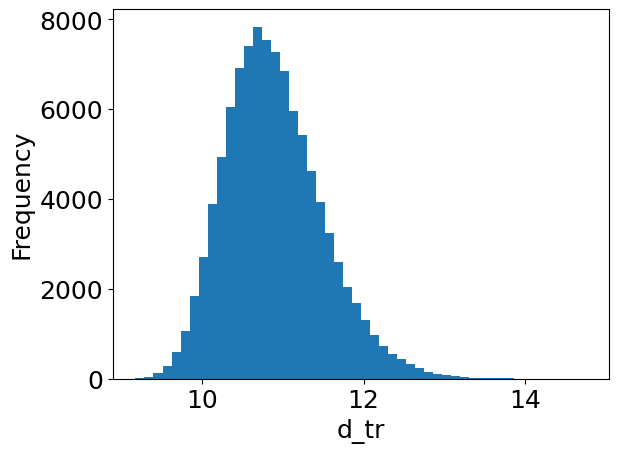

In [7]:
plt.rcParams["font.size"] = 18
plt.hist(dtr, bins=50)
plt.xlabel("d_tr")
plt.ylabel("Frequency")  
plt.savefig("hist_dtr.eps", bbox_inches='tight')

# Figure 3 for small artificial data

In [198]:
# N=32
# y = np.vstack([np.zeros([N,1]), np.ones([N,1])])
# xa_train = np.array([1.0, 1.0, 0.0]) + np.dot(np.random.rand(N,1)*16, np.ones([1,3])) + np.random.randn(N,3)*2 # [0.0, 1.0, 2.0]
# xb_train = np.array([-1.0, -1.0, 0.0]) + np.dot(np.random.rand(N,1)*16, np.ones([1,3])) + np.random.randn(N,3)*2 # [0.0, -2.0, -1.0]
# x_train = np.vstack([xa_train, xb_train])
# xa_test = np.array([1.0, 1.0, 0.0]) + np.dot(np.random.rand(N,1)*16, np.ones([1,3])) + np.random.randn(N,3)*2 # [0.0, 1.0, 2.0]
# xb_test = np.array([-1.0, -1.0, 0.0]) + np.dot(np.random.rand(N,1)*16, np.ones([1,3])) + np.random.randn(N,3)*2 # [0.0, -2.0, -1.0]
# x_test = np.vstack([xa_test, xb_test])

N=16
y = np.vstack([np.zeros([N,1]), np.ones([N,1])])
xa_train = np.array([0.5, -0.5]) + np.dot(randn(N,1)*4, np.ones([1,2])) + randn(N,2)
xb_train = np.array([-0.5, 0.5]) + np.dot(randn(N,1)*4, np.ones([1,2])) + randn(N,2)
x_train = np.vstack([xa_train, xb_train])
xa_test = np.array([0.5, -0.5]) + np.dot(randn(N,1)*4, np.ones([1,2])) + randn(N,2)
xb_test = np.array([-0.5, 0.5]) + np.dot(randn(N,1)*4, np.ones([1,2])) + randn(N,2)
x_test = np.vstack([xa_test, xb_test])

In [165]:
model_tropical = Sequential([TropEmbed(16, 2), Dense(1, activation="sigmoid")])
model_tropical.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
model_tropical.fit(x_train, y, verbose=0, epochs=10)
y_pred_tropical = model_tropical.predict(x_test)
((y_pred_tropical > 0.5) == y).mean()

1/1 [==============================] - 0s 79ms/step


0.78125

In [166]:
model = Sequential([Dense(16, input_shape=(2,), activation="relu"), Dense(1, activation="sigmoid")])
model.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y, verbose=0, epochs=10)
y_pred = model.predict(x_test)
((y_pred > 0.5) == y).mean()

1/1 [==============================] - 0s 47ms/step


0.8125

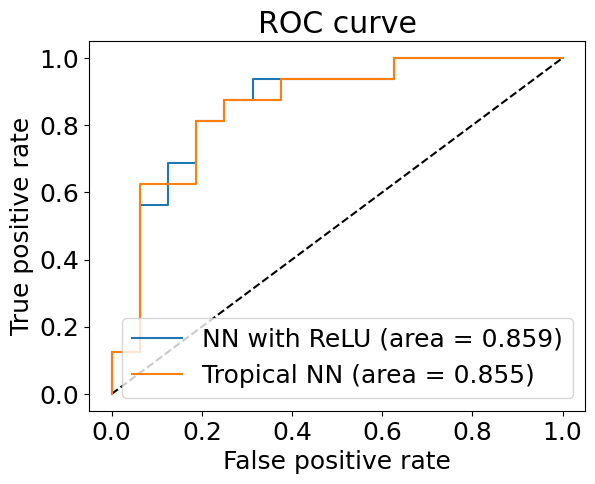

In [167]:
# draw ROC curve (not used in paper)
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y, y_pred)
fpr_tropical, tpr_tropical, thresholds_tropical = roc_curve(y, y_pred_tropical)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN with ReLU (area = {:.3f})'.format(auc(fpr, tpr)))
plt.plot(fpr_tropical, tpr_tropical, label='Tropical NN (area = {:.3f})'.format(auc(fpr_tropical, tpr_tropical)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

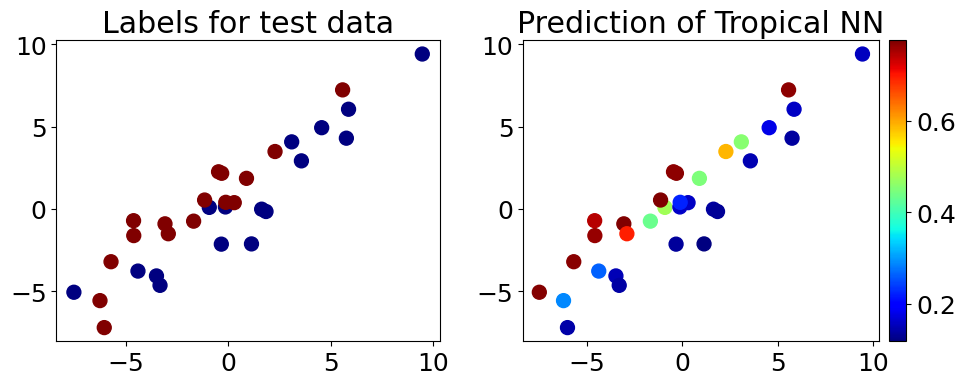

In [168]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=[10, 4.2])

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x_test[:,0], x_test[:,1], s=100, c=y, cmap="jet")
ax1.set_title("Labels for test data")
ax2 = fig.add_subplot(1, 2, 2)
im2 = ax2.scatter(x_test[:,0], x_test[:,1], s=100, c=y_pred_tropical, cmap='jet')
ax2.set_title("Prediction of Tropical NN")

divider2 = make_axes_locatable(ax2)
cax = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax)

plt.tight_layout()

plt.savefig("small_data.eps")

# Figure 4 for high dimensional artificial data

In [ ]:
N_repeat=100; N=16; dimension=[4, 8, 16, 32, 64, 128, 256, 512]; # avoid dim=2 which is too special
ACC_tr = np.zeros([len(dimension), N_repeat])
ACC_cl = np.zeros([len(dimension), N_repeat])
for i in range(len(dimension)):
    d = dimension[i]
    print(d)
    for repeat in range(0, N_repeat):
        # data generation
        y = np.vstack([np.zeros([N,1]), np.ones([N,1])])
        xa_train = np.hstack([[3,-3],np.zeros(d-2)]) + np.dot(randn(N,1)*6, np.ones([1,d])) + randn(N,d) # sigma=3: classical one better for N<16
        xb_train = np.hstack([[-3,3],np.zeros(d-2)]) + np.dot(randn(N,1)*6, np.ones([1,d])) + randn(N,d) # sigma=6: used for paper figure
        x_train = np.vstack([xa_train, xb_train])
        xa_test = np.hstack([[3,-3],np.zeros(d-2)]) + np.dot(randn(N,1)*6, np.ones([1,d])) + randn(N,d)
        xb_test = np.hstack([[-3,3],np.zeros(d-2)]) + np.dot(randn(N,1)*6, np.ones([1,d])) + randn(N,d)
        x_test = np.vstack([xa_test, xb_test])
    
        # tropical NN
        model_tropical = Sequential([TropEmbed(8, d), Dense(1, activation="sigmoid")])
        model_tropical.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
        model_tropical.fit(x_train, y, verbose=0, epochs=10)
        ACC_tr[i,repeat] = ((model_tropical.predict(x_test, verbose=0) > 0.5) == y).mean()
    
        # classical NN with ReLU
        model = Sequential([Dense(8, input_shape=(d,), activation="relu"), Dense(1, activation="sigmoid")])
        model.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
        model.fit(x_train, y, verbose=0, epochs=10)
        ACC_cl[i,repeat] = ((model.predict(x_test, verbose=0) > 0.5) == y).mean()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


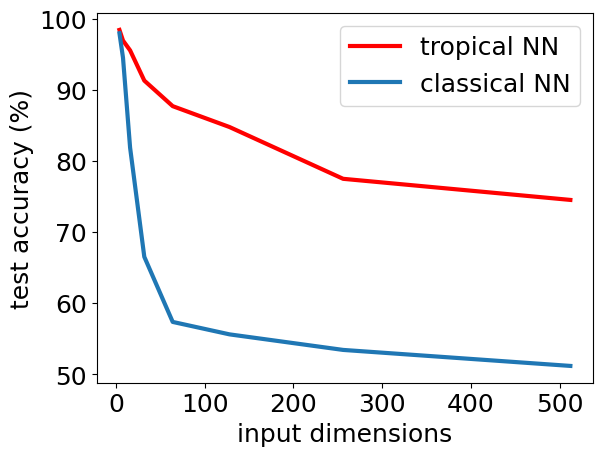

In [243]:
plt.rcParams["font.size"] = 18
plt.plot(dimension, ACC_tr.mean(axis=1)*100, linewidth=3, c="red", label="tropical NN")
plt.plot(dimension, ACC_cl.mean(axis=1)*100, linewidth=3, label="classical NN")
plt.xlabel("input dimensions")
plt.ylabel("test accuracy (%)")
plt.legend()
plt.savefig("high_dim_data_8neurons.eps", bbox_inches='tight')

# Figure 6 for ROC curves

In [11]:
D1 = np.loadtxt("R025genetrees_S1.csv", delimiter=",", skiprows=1, usecols=range(1,46)) # to change R
D2 = np.loadtxt("R025genetrees_S2.csv", delimiter=",", skiprows=1, usecols=range(1,46)) # change filenames only
D = np.concatenate((D1,D2))
Y1 = np.array([[0],[0]]*500)
Y2 = np.array([[1],[1]]*500)
Y = np.concatenate((Y1,Y2))
DD = np.append(Y, D, axis=1)
import random
l = np.arange(0, 2000)
np.random.shuffle(l)
train = l[0:999]
test = l[1000:1999]
x_train = D[train,]
x_test = D[test,]
y_train = Y[train]
y_test = Y[test] 
D.shape

(2000, 45)

In [12]:
model_tropical = Sequential([TropEmbed(1000, 45), Dense(1, activation="sigmoid")])
model_tropical.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
model_tropical.fit(x_train, y_train, epochs=10)
((model_tropical.predict(x_test) > 0.5).reshape([999,]) == y_test).mean()

Epoch 1/10
32/32 [==============================] - 2s 31ms/step - loss: 25.8728 - accuracy: 0.5495
Epoch 2/10
32/32 [==============================] - 1s 26ms/step - loss: 4.2063 - accuracy: 0.6476
Epoch 3/10
32/32 [==============================] - 1s 26ms/step - loss: 4.2795 - accuracy: 0.7157
Epoch 4/10
32/32 [==============================] - 1s 26ms/step - loss: 3.6425 - accuracy: 0.7377
Epoch 5/10
32/32 [==============================] - 1s 25ms/step - loss: 6.5672 - accuracy: 0.6837
Epoch 6/10
32/32 [==============================] - 1s 26ms/step - loss: 2.0484 - accuracy: 0.7858
Epoch 7/10
32/32 [==============================] - 1s 26ms/step - loss: 2.7663 - accuracy: 0.7778
Epoch 8/10
32/32 [==============================] - 1s 26ms/step - loss: 2.0084 - accuracy: 0.7958
Epoch 9/10
32/32 [==============================] - 1s 26ms/step - loss: 21.2734 - accuracy: 0.6036
Epoch 10/10
32/32 [==============================] - 1s 22ms/step


0.5016608199791383

In [13]:
model = Sequential([Dense(1000, input_shape=(45,), activation="relu"), Dense(1, activation="sigmoid")])
model.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=10)
((model.predict(x_test) > 0.5).reshape([999,]) == y_test).mean()

Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 8.7775 - accuracy: 0.5025
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6517 - accuracy: 0.6527
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5746
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.6246 - accuracy: 0.6476
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5963 - accuracy: 0.6957
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5610 - accuracy: 0.7267
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5782 - accuracy: 0.7067
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5435 - accuracy: 0.7317
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.5376 - accuracy: 0.7337
Epoch 10/10
32/32 [==============================] - 0s 1ms/step


0.4993712431149869

In [14]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

32/32 [==============================] - 0s 882us/step


In [15]:
y_pred_keras_tropical = model_tropical.predict(x_test).ravel()
fpr_keras_tropical, tpr_keras_tropical, thresholds_keras_tropical = roc_curve(y_test, y_pred_keras_tropical)
auc_keras_tropical = auc(fpr_keras_tropical, tpr_keras_tropical)

32/32 [==============================] - 1s 22ms/step


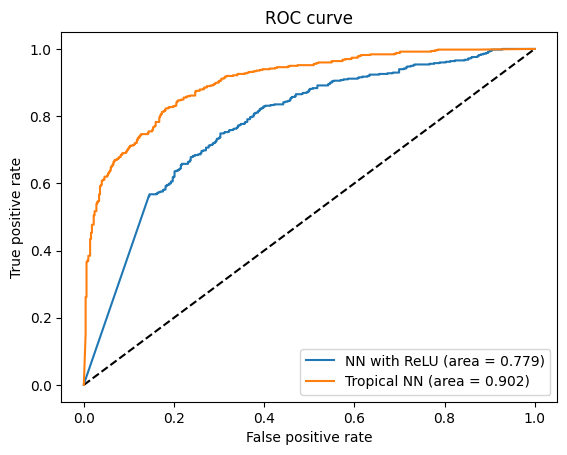

In [16]:
import matplotlib.pyplot as plt 
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='NN with ReLU (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras_tropical, tpr_keras_tropical, label='Tropical NN (area = {:.3f})'.format(auc_keras_tropical))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Figure 7 for flu data (data not available)

In [2]:
from sklearn.metrics import auc, roc_curve
import seaborn as sns
import pandas as pd

def train_model(x_train,y_train,hidden_layer):
    model = Sequential([hidden_layer,Dense(1, activation="sigmoid")])
    model.compile(optimizer=Adam(0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=5, verbose=0)
    return model

def train_classical_model(x_train,y_train,num_neurons=10):
    tree_dim = x_train.shape[1] 
    hidden_layer = Dense(num_neurons, input_shape=(tree_dim,), activation="relu")
    return train_model(x_train,y_train,hidden_layer)

def train_tropical_model(x_train,y_train,num_neurons=10):
    tree_dim = x_train.shape[1] 
    hidden_layer = TropEmbed(num_neurons, tree_dim)
    return train_model(x_train,y_train,hidden_layer)

def get_accuracy(y_test_pred,y_test):
    p_thres = 0.5
    acc = ((y_test_pred > p_thres).reshape([-1,]) == y_test.reshape([-1,])).mean()
    return acc 

def get_auc(y_test_pred,y_test,plot_roc=False):
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    if plot_roc:    
        plt.plot(fpr,tpr)
        plt.show()
    return auc(fpr, tpr)

def classify_flu_trees(year1,year2,model="tropical"):
    # Returns the AUC 
    D1 = D[year1 - 1993]
    D2 = D[year2 - 1993]

    len1 = D1.shape[0]
    len2 = D2.shape[0]
    x = np.vstack([D1,D2])
    y = np.hstack([np.repeat(0, len1), np.repeat(1, len2)]).reshape((len1+len2,1))

    l = np.arange(0, len1+len2)
    np.random.shuffle(l)
    train_size = int(0.8 * (len1+len2))
    train = l[0:train_size]
    test = l[train_size:]

    x_train = x[train,]
    x_test = x[test,]
    y_train = y[train]
    y_test = y[test]

    if model == "tropical":
        trained_model = train_tropical_model(x_train,y_train)
    elif model == "classical":
        trained_model = train_classical_model(x_train,y_train)
    else:
        raise Exception("Method not found")
    
    y_test_pred = trained_model.predict(x_test, verbose=0)
    aucval = get_auc(y_test_pred,y_test)
    print(f"The AUC for years {year1} and {year2} is {round(aucval,3)}.")
    return aucval

In [ ]:
D = []
for i in range(1993,2014):
    fn = "NYh3n2_HA_20000_5_" + str(i) + ".csv"
    D.append(np.loadtxt(fn, delimiter=",", skiprows=1, usecols=range(1,11)))

max_year = 2014
L = max_year - 1993
np.random.seed(1)
tf.random.set_seed(1)

# TROPICAL 
mat = 0.5 * np.ones((L,L))
for year1 in range(1993,max_year):    
    for year2 in range(year1+1,max_year):
        mat[year1-1993,year2-1993] = classify_flu_trees(year1,year2,model="tropical")

mat = mat + np.transpose(mat) - 0.5 * np.ones((L,L)) #symmetric matrix
labels = list(range(1993,max_year))
df = pd.DataFrame(mat,index= labels, columns= labels )
sns.heatmap(df,vmin=0.5,vmax=1)
plt.title("AUC values for tropical NN")
plt.show()

# CLASSICAL
mat = 0.5 * np.ones((L,L))
for year1 in range(1993,max_year):    
    for year2 in range(year1+1,max_year): 
        mat[year1-1993,year2-1993] = max(mat[year1-1993,year2-1993],classify_flu_trees(year1,year2,model="classical"))

mat = mat + np.transpose(mat) - 0.5 * np.ones((L,L)) #symmetric matrix
labels = list(range(1993,max_year))
df = pd.DataFrame(mat,index= labels, columns= labels )
sns.heatmap(df,vmin=0.5,vmax=1)
plt.title("AUC values for classical NN")
plt.show()

The AUC for years 1993 and 1994 is 0.961.
